In [1]:
using JuMP, Gurobi, Plots, Random,  LaTeXStrings

In [2]:
# A helper function for returning an array of possible paths (cartesian indices) 
# for nodes whose number of states is defined by the vector arr
function cart(arr)
    cart_arr = CartesianIndices(zeros(Tuple(arr)))
    index_arr = []
    for index in cart_arr
        push!(index_arr, [elem for elem in Tuple(index)])
    end
    return index_arr
end

cart (generic function with 1 method)

In [3]:
function solve_pigfarm(n_stages; verbose=false)
    
    # Index sets
    N = 1:n_stages
    H = 1:2 # Ill/healthy
    T = 1:2 # +/-
    D = 1:2 # Treat/pass
    # The reason we introduce states for value nodes is that they could be stochastic
    U_treat = 1:2 # Treat/pass 
    U_sell = 1:2 # Ill/healthy

    CN = N[end]
    CH = H[end]
    CT = T[end]
    CD = D[end]

    # Treatment costs 
    cost_treat = zeros(length(D),length(U_treat))
    cost_treat[1,1] = -100

    # Profit from selling the pig in the end
    profit_sell = zeros(length(H),length(U_sell))
    profit_sell[1,1] = 300
    profit_sell[2,2] = 1000

    # Initial probability of pig being ill/healthy
    p_init = [0.1 0.9]

    # Transition probabilities of the health states
    p_trans = zeros(length(H),length(D),length(H))
    p_trans[1,1,:] = [0.5 0.5] # Ill, treated
    p_trans[1,2,:] = [0.9 0.1] # Ill, not treated
    p_trans[2,1,:] = [0.1 0.9] # Healthy, treated
    p_trans[2,2,:] = [0.2 0.8] # Healthy, not treated

    # Probabilities of getting positive/negative result from the test
    p_res = zeros(length(H),length(T))
    p_res[1,:] = [0.8 0.2] # Ill
    p_res[2,:] = [0.1 0.9] # Healthy

    model = Model()
    if !verbose
        set_silent(model)
    end
    optimizer = optimizer_with_attributes(
        () -> Gurobi.Optimizer(Gurobi.Env()),
        "IntFeasTol"      => 1e-9,
        "TimeLimit"       => 3600,
        # "DualReductions"  => 0,
    )
    set_optimizer(model, optimizer)

    @variable(model, δ[N,T,D], Bin)

    vec_μ_ht = Vector{Array{VariableRef}}(undef, n_stages)
    vec_μ_htd = Vector{Array{VariableRef}}(undef, n_stages)
    vec_μ_hdh = Vector{Array{VariableRef}}(undef, n_stages)
    @variable(model, μ_h0[H] >= 0)

    for  n in N
        μ_ht = Array{VariableRef}(undef, ([fill(CD,n-1)...,CH,CT]...))
        for index in CartesianIndices(μ_ht)
            μ_ht[index] = @variable(model, base_name="μ_ht[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_ht[n] = μ_ht
        μ_htd = Array{VariableRef}(undef, ([fill(CD,n-1)...,CH,CT,CD ]...))
        for index in CartesianIndices(μ_htd)
            μ_htd[index] = @variable(model, base_name="μ_htd[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_htd[n] = μ_htd
        μ_hdh = Array{VariableRef}(undef, ([fill(CD,n-1)...,CD,CH,CH ]...))
        for index in CartesianIndices(μ_hdh)
            μ_hdh[index] = @variable(model, base_name="μ_hdh[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_hdh[n] = μ_hdh
    end

    μ_u = Array{VariableRef}(undef, ([fill(CD,CN)...,CH]...))
    for index in CartesianIndices(μ_u)
        μ_u[index] = @variable(model, base_name="μ_u[$(join(Tuple(index),','))]", lower_bound=0)
    end

    @objective(model, Max, sum(μ_u[d,h]*(sum(cost_treat[d1,d1] for d1 in Tuple(d))+profit_sell[h,h]) for d in CartesianIndices((fill(D,CN)...,)), h in H))



    @constraint(model, sum(μ_h0) == 1)
    @constraint(model,[n in N],sum(vec_μ_hdh[n]) == 1 )
    @constraint(model,[n in N],sum(vec_μ_htd[n]) == 1 )
    @constraint(model,[n in N],sum(vec_μ_ht[n]) == 1 )
    @constraint(model,sum(μ_u) == 1)


    for  n in N
        if n == 1
            @constraint(model,[h in H] ,μ_h0[h] == sum(vec_μ_ht[1][h,t] for t in T))
        else
            for d in CartesianIndices((fill(D,n-1)...,))
                @constraint(model,[h in H] ,sum(vec_μ_hdh[n-1][Tuple(d)[1:(end-1)]...,hh,Tuple(d)[end],h] for hh in H) == sum(vec_μ_ht[n][Tuple(d)...,h,t] for t in T))
            end
        end
        for d in CartesianIndices((fill(D,n-1)...,))
            @constraint(model,[h in H, t in T],sum(vec_μ_htd[n][Tuple(d)...,h,t,d2] for d2 in D) == vec_μ_ht[n][Tuple(d)...,h,t] )
            @constraint(model,[h in H,d2 in D],sum(vec_μ_htd[n][Tuple(d)...,h,t,d2] for t in T) == sum(vec_μ_hdh[n][Tuple(d)...,h,d2,hh] for hh in H))
        end
    end

    for d in CartesianIndices((fill(D,N[end]-1)...,))
        @constraint(model,[h in H, d2 in D], μ_u[Tuple(d)...,d2,h] == sum(vec_μ_hdh[N[end]][Tuple(d)...,hh,d2,h] for hh in H) )
    end


     # Moments μ_{\breve{C}_v} (the moments from above, but with the last variable dropped out)
    # Some such moments were already created
    vec_μ_hdh_br = Vector{Array{VariableRef}}(undef, CN)
    vec_μ_htd_br = Vector{Array{VariableRef}}(undef, CN)
    vec_μ_ht_br = Vector{Array{VariableRef}}(undef, CN)
    for n in 1:N[end]
        μ_hdh_br = Array{VariableRef}(undef, ([fill(CD,n-1)...,CD,CH]...))
        for index in CartesianIndices(μ_hdh_br)
            μ_hdh_br[index] = @variable(model, base_name="μ_hdh_br[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_hdh_br[n] = μ_hdh_br
        μ_htd_br = Array{VariableRef}(undef, ([fill(CD,n-1)...,CH,CT ]...))
        for index in CartesianIndices(μ_htd_br)
            μ_htd_br[index] = @variable(model, base_name="μ_htd_br[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_htd_br[n] = μ_htd_br
        μ_ht_br = Array{VariableRef}(undef, ([fill(CD,n-1)...,CH]...))
        for index in CartesianIndices(μ_ht_br)
            μ_ht_br[index] = @variable(model, base_name="μ_ht_br[$(join(Tuple(index),','))]", lower_bound=0)
        end
        vec_μ_ht_br[n] = μ_ht_br
    end


    for n in 1:N[end]
        for d in CartesianIndices((fill(D,n-1)...,))
            @constraint(model,[h in H, t in T],sum(vec_μ_htd[n][Tuple(d)...,h,t,d2] for d2 in D) == vec_μ_htd_br[n][Tuple(d)...,h,t] )
            @constraint(model,[h in H,d2 in D],sum(vec_μ_hdh[n][Tuple(d)...,h,d2,hh] for hh in H) == vec_μ_hdh_br[n][Tuple(d)...,h,d2])
            @constraint(model,[h in H],sum(vec_μ_ht[n][Tuple(d)...,h,t] for t in T) == vec_μ_ht_br[n][Tuple(d)...,h])
        end
    end


    @constraint(model,[h in H], μ_h0[h] == p_init[h])
    for n in 1:N[end]
        for d in CartesianIndices((fill(D,n-1)...,))
            @constraint(model,[h in H, t in T, d2 in D],vec_μ_htd[n][Tuple(d)...,h,t,d2] == vec_μ_htd_br[n][Tuple(d)...,h,t]*δ[n,t,d2] )
            @constraint(model,[h in H,d2 in D, hh in H],vec_μ_hdh[n][Tuple(d)...,h,d2,hh] == vec_μ_hdh_br[n][Tuple(d)...,h,d2]*p_trans[h,d2,hh])
            @constraint(model,[h in H,t in T],vec_μ_ht[n][Tuple(d)...,h,t] == vec_μ_ht_br[n][Tuple(d)...,h]*p_res[h,t])
        end
    end

    optimize!(model)
    return objective_value(model), value.(δ), solve_time(model)
end

solve_pigfarm (generic function with 1 method)

In [4]:
N_arr = [1; 2; 3; 4; 5; 6; 7; 8]
sol_times = []
n_sample = 10
for N in N_arr
    println(N)
    total_time = 0
    for i in 1:n_sample
        _, _, t = solve_pigfarm(N)
        total_time+=t
    end
    push!(sol_times, total_time/n_sample)
end

1
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.

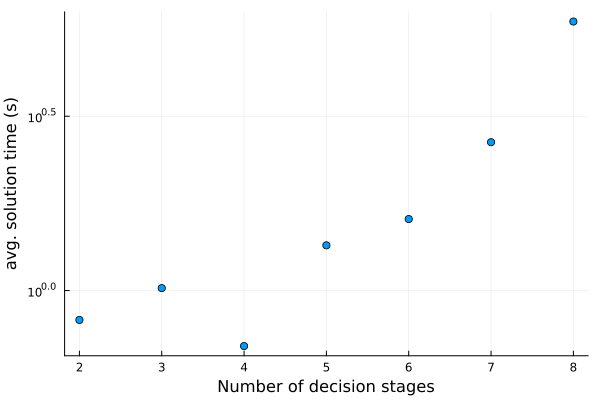

In [8]:
using Plots
scatter(N_arr[2:end], sol_times[2:end], xlabel="Number of decision stages", ylabel="avg. solution time (s)", label=false, yaxis=:log)

In [9]:
sol_times[2:end]

7-element Vector{Any}:
 0.823613977432251
 1.0163811206817628
 0.6932491779327392
 1.348180627822876
 1.6035841703414917
 2.6639718055725097
 5.909097528457641